# Inertial navigation system simulation

In this example, we demonstrate simulation of inertial navigation system
([`INS`][inertialsim.sensors.ins]) sensors and use of the
[symbolic][inertialsim.symbolic] module.

Inertial navigation systems (INS) are sensors but unlike gyros, accelerometers,
IMUs, or magnetometers they do not directly measure physical phenomena.  Instead
they use IMU data and software algorithms to calculate attitude (orientation),
position, and velocity.  This is sometimes referred to as *free* INS and
InertialSim contains a complete, state-of-the-art implementation of the
equations of inertial navigation.

Free INS is the basis for *aided* INS, whereby cumulative errors are corrected
or reset by another, independent aiding sensor.  InertialSim also supports the
simulation of aided INS sensors.  The examples below demonstrate both.

!!! note "Aided INS sensors"
    Many commercial INS sensors are aided by additional inputs.  Navigation
    satellite (GNSS) inputs are the most common but aiding sensors can include
    magnetometers, vision sensors (star trackers, cameras, lidars) and others.
    Given the diversity and complexity of these aiding inputs, and the fact that
    they are typically integrated via proprietary algorithms, it can be
    difficult to standardize a model of their effect on INS outputs.  If you are
    interested in custom simulation of aided INS outputs, please [get in
    touch](../contact/index.md)!

## Setup

We first define a symbolic trajectory.  This is a representation of attitude
(orientation) and position by exact analytic equations.  We then use
InertialSim's symbolic processing module to derive exact symbolic IMU
measurements.  We define an ideal (error-free) INS sensor and input ideal
(error-free) sampled IMU measurements.  The resulting outputs are subject only
to numerical integration error.

Building on this, we demonstrate simulating sources of error in the IMU and INS
and analyzing their effect on INS outputs.  We then demonstrate resetting
accumulated error as in an aided INS.

!!! note "Supported coordinate systems"
    INS sensor simulation is supported in global (geodetic, ECEF, topocentric)
    and local coordinate systems with complete support for Earth rate effects
    and advanced gravity models.  The INS sensor inherits the coordinate system,
    datums, and models specified in the initial conditions.  The symbolic module
    currently supports Cartesian coordinate systems with simplified gravity
    models.

## Define symbolic trajectory

We use the built-in [`ZigZagTrajectory`][inertialsim.symbolic.ZigZagTrajectory]
which is characterized by oscillatory motion in most axes.  We demonstrate a
short, aggressively maneuvering trajectory that is representative of drone
motion or similar applications.

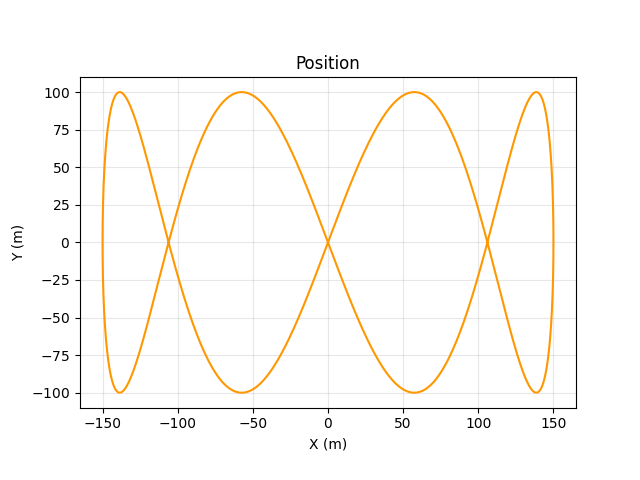

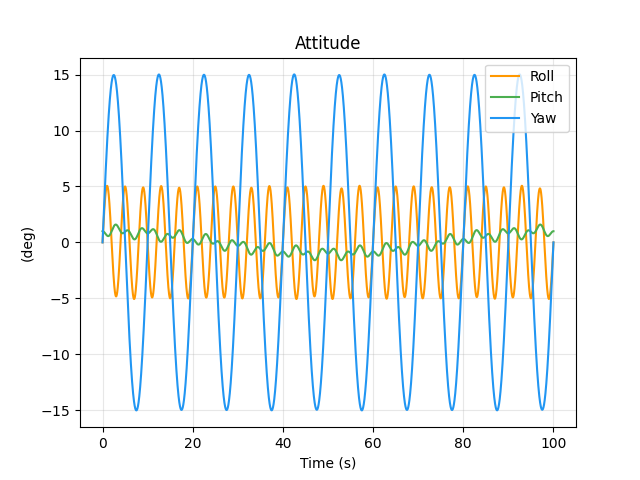

In [1]:
# -----------------------------------------------------------------------------
# Copyright (c) 2023-2025, Inertial Simulation LLC.
# This example is licensed under the CC BY-NC-SA 4.0 license.
# https://creativecommons.org/licenses/by-nc-sa/4.0/
# Email: info@inertialsim.com
# -----------------------------------------------------------------------------
%matplotlib widget

import numpy as np

from inertialsim import plot
from inertialsim.symbolic import ZigZagTrajectory
from inertialsim.time import span

# Zigzag motion profile.  Representative of a holonomic vehicle like a drone or
# helicopter. A periodic zigzag profile in xy position, with independent
# oscillation in z. Independent oscillations in roll, pitch, yaw. Sampled at
# 100Hz for 100 seconds.
dt = 0.01
duration = 100.0
time = span(0, duration, dt)
zigzag = ZigZagTrajectory(
    attitude_amplitudes=np.deg2rad(np.array([5.0, 1.0, 15.0])),
    attitude_frequencies=np.array([0.25, 0.01, 0.1]),
    position_amplitudes=np.array([150, 200, 5]),
    position_frequencies=np.array([0.01, 0.02, 0.034]),
)

position = zigzag.position(time)
p_plot = plot.Scatter(title="Position", xlabel="X (m)", ylabel="Y (m)")
p_plot.line(zigzag.position(time)[:, 0], zigzag.position(time)[:, 1])
p_plot.axes.set_aspect("equal")

a_plot = plot.TimeSeries(title="Attitude", ylabel="(deg)")
a_plot.line(time, np.rad2deg(zigzag.rotation(time).as_euler("XYZ")))
a_plot.legend(["Roll", "Pitch", "Yaw"])

In [2]:
from matplotlib import pyplot as plt
from inertialsim.geometry import ExtendedPose

plt.rcParams["axes.prop_cycle"] = plt.cycler(
    "color",
    [
        "#FF9800",
        "#4CAF50",
        "#2196F3",
        "#FF5722",
        "#009688",
        "#3F51B5",
        "#9E9E9E",
    ],
)


def plot_errors(results, trajectory, title="", legend=None):
    if not isinstance(results, list):
        results = [results]

    # Assume time is same for all results
    time = results[0].attitude.time

    position = trajectory.position(time)[:, :, 0]
    p_plot = plot.Scatter(
        title="Position Comparison" + title, xlabel="X (m)", ylabel="Y (m)"
    )
    p_plot.line(position[:, 0], position[:, 1])
    p_plot.axes.set_aspect("equal")

    figure, axes = plt.subplots(3, sharex=True, figsize=(6.4, 6.4), dpi=100)
    figure.suptitle("INS Errors" + title)
    axes[0].set_ylabel("Attitude (deg)")
    axes[0].set_facecolor("white")
    axes[0].grid(visible=True, alpha=0.3)
    axes[0].ticklabel_format(style="sci", axis="y", scilimits=(-2, 4), useMathText=True)
    axes[1].set_ylabel("Position (m)")
    axes[1].set_facecolor("white")
    axes[1].grid(visible=True, alpha=0.3)
    axes[1].ticklabel_format(style="sci", axis="y", scilimits=(-2, 4), useMathText=True)
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylabel("Velocity (m/s)")
    axes[2].set_facecolor("white")
    axes[2].grid(visible=True, alpha=0.3)
    axes[2].ticklabel_format(style="sci", axis="y", scilimits=(-2, 4), useMathText=True)
    for result in results:
        p_plot.line(result.position.data[:, 0], result.position.data[:, 1])
        axes[0].plot(
            time[:, :, 0],
            np.rad2deg(
                result.attitude.data[:, :, 0]
                - trajectory.rotation(time).as_euler("XYZ")[:, :, 0]
            ),
        )
        axes[1].plot(
            time[:, :, 0],
            result.position.data[:, :, 0] - trajectory.position(time)[:, :, 0],
        )
        axes[2].plot(
            time[:, :, 0],
            result.velocity.data[:, :, 0] - trajectory.velocity(time)[:, :, 0],
        )

    plt.subplots_adjust(hspace=0.3, top=0.93)
    p_plot.legend(["Ground truth", "INS"], "lower right")
    axes[0].legend(["Roll", "Pitch", "Yaw"])
    axes[1].legend(["X", "Y", "Z"])
    axes[2].legend(["X", "Y", "Z"])


def plot_average_errors(results, trajectory, title="", legend=None):
    num_results = len(results)
    time = results[0].attitude.time
    a_error = np.zeros((num_results, time.shape[0], 1, 1))
    p_error = np.zeros((num_results, time.shape[0], 1, 1))
    v_error = np.zeros((num_results, time.shape[0], 1, 1))

    for idx, result in enumerate(results):
        pose = ExtendedPose.from_apv(
            result.attitude.data, result.position.data, result.velocity.data, time
        )
        a_error[idx], p_error[idx], v_error[idx] = pose.error(
            trajectory.extended_pose(time)
        )

    a_mean = np.rad2deg(np.mean(a_error, axis=0))
    a_std = np.rad2deg(np.std(a_error, axis=0))
    p_mean = np.mean(p_error, axis=0)
    p_std = np.std(p_error, axis=0)
    v_mean = np.mean(v_error, axis=0)
    v_std = np.std(v_error, axis=0)

    figure, axes = plt.subplots(3, sharex=True, figsize=(6.4, 6.4), dpi=100)
    figure.suptitle("INS Error Statistics" + title)
    axes[0].set_ylabel("Attitude (deg)")
    axes[0].set_facecolor("white")
    axes[0].grid(visible=True, alpha=0.3)
    axes[0].ticklabel_format(style="sci", axis="y", scilimits=(-2, 4), useMathText=True)
    axes[1].set_ylabel("Position (m)")
    axes[1].set_facecolor("white")
    axes[1].grid(visible=True, alpha=0.3)
    axes[1].ticklabel_format(style="sci", axis="y", scilimits=(-2, 4), useMathText=True)
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylabel("Velocity (m/s)")
    axes[2].set_facecolor("white")
    axes[2].grid(visible=True, alpha=0.3)
    axes[2].ticklabel_format(style="sci", axis="y", scilimits=(-2, 4), useMathText=True)
    axes[0].plot(time[:, :, 0], a_mean[:, :, 0], color="#2196F3")
    axes[0].plot(
        time[:, :, 0], a_mean[:, :, 0] + a_std[:, :, 0], "#F44336", ls="--", alpha=0.5
    )
    axes[0].plot(
        time[:, :, 0], a_mean[:, :, 0] - a_std[:, :, 0], "#F44336", ls="--", alpha=0.5
    )
    axes[1].plot(time[:, :, 0], p_mean[:, :, 0], color="#2196F3")
    axes[1].plot(
        time[:, :, 0], p_mean[:, :, 0] + p_std[:, :, 0], "#F44336", ls="--", alpha=0.5
    )
    axes[1].plot(
        time[:, :, 0], p_mean[:, :, 0] - p_std[:, :, 0], "#F44336", ls="--", alpha=0.5
    )
    axes[2].plot(time[:, :, 0], v_mean[:, :, 0], color="#2196F3")
    axes[2].plot(
        time[:, :, 0], v_mean[:, :, 0] + v_std[:, :, 0], "#F44336", ls="--", alpha=0.5
    )
    axes[2].plot(
        time[:, :, 0], v_mean[:, :, 0] - v_std[:, :, 0], "#F44336", ls="--", alpha=0.5
    )

    plt.subplots_adjust(hspace=0.3, top=0.93)
    axes[0].legend(["Average", "1-sigma"])
    axes[1].legend(["Average", "1-sigma"])
    axes[2].legend(["Average", "1-sigma"])

## Source IMU data

For the purposes of INS simulation, the input IMU data can be recorded by real
sensors; generated by numerical simulation via the
[`IMU`][inertialsim.sensors.imu.IMU] class or a third-party tool; or generated
from the [symbolic][inertialsim.symbolic] module.

In this example, we use the [symbolic][inertialsim.symbolic] module option.  We
sample the IMU data at 100Hz and plot it.  Because this data is sampled from
symbolic representations it is exact and error free.

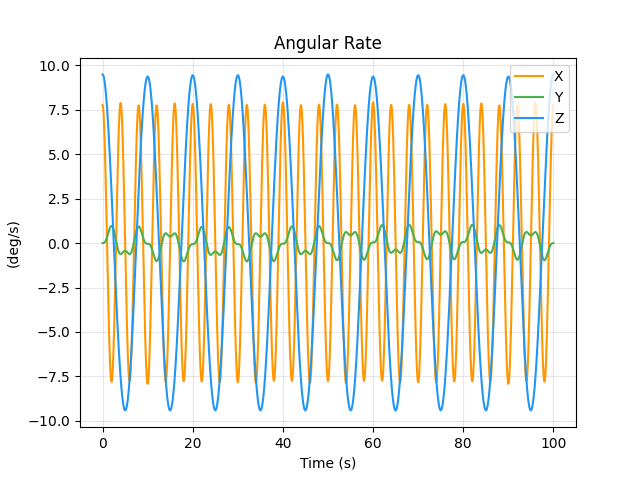

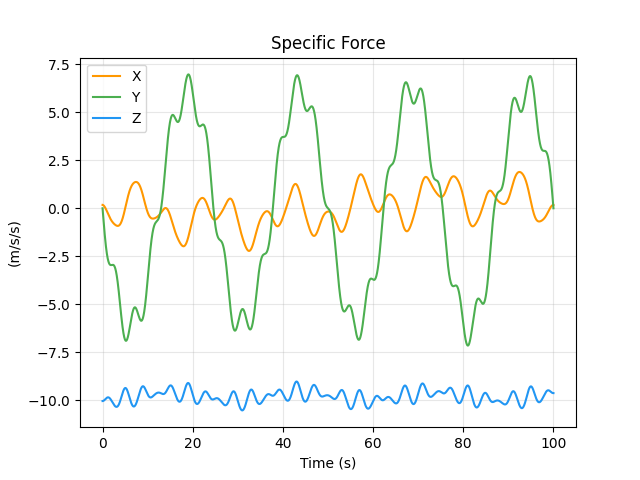

In [3]:
# Sample IMU (gyro & accelerometer) data at the previously specified 100Hz
angular_rate = zigzag.angular_rate(time)
specific_force = zigzag.specific_force(time)

w_plot = plot.TimeSeries(title="Angular Rate", ylabel="(deg/s)")
w_plot.line(time, np.rad2deg(angular_rate))
w_plot.legend(["X", "Y", "Z"])

a_plot = plot.TimeSeries(title="Specific Force", ylabel="(m/s/s)")
a_plot.line(time, specific_force)
a_plot.legend(["X", "Y", "Z"])

The gyro measurements are mostly oscillatory, with moderate rates in the x-axis
and z-axis.  We can observe the gravity component in the z-axis of the specific
force. The y-axis contains periodic accelerations nearing a maximum of +/- 1g.

## Create an ideal INS sensor

Next we create an INS sensor and simulate its behavior.  Like all other sensors
in InertialSim, INS sensors are characterized by a model and a specification.
The model specifies what to simulate and the specification includes the relevant
physical and numerical properties of the sensor.

INS sensors support simulation of IMU errors, initial condition errors, gravity
errors, timing errors, and numerical errors.

See the [reference](../reference/model.md) documentation and
[API][inertialsim.sensors.ins] for complete details.

In [4]:
from inertialsim.sensors.ins import (
    INS,
    INSModel,
    INSSpecification,
    AttitudeFormat,
    Integrator,
)
from inertialsim.geometry import Vector
from inertialsim.geodesy import GlobalPose, Gravity

# Simulate ideal (error-free) INS that outputs attitude in Euler angle format
# and uses a trapezoidal numerical integrator.
model = INSModel()
model.set_all(value=False)
model.data_interface.attitude_format = AttitudeFormat.EULER_ANGLE
model.numerical_methods.integrator = Integrator.TRAPEZOID

# Default (error-free) specification
specification = INSSpecification()

# Create the INS
ins = INS(model, specification, rng=0)

# The INS inherits the navigation/global frame and related properties from the
# initial conditions.  In this case, a local frame with standard gravity
# (9.80665 m/s/s) and the initial attitude, position, and velocity of the zigzag
# trajectory defined earlier.
initial_conditions = GlobalPose.from_local(
    pose=zigzag.extended_pose(time[0]), gravity=Gravity.standard()
)
ins.initialize(initial_conditions)

# Simulation inputs are IMU data in Vector or Measurement form
angular_rate = Vector.from_xyz(angular_rate, time)
specific_force = Vector.from_xyz(specific_force, time)

# The result is attitude, position, and velocity in an INSData structure
results = ins.simulate(angular_rate=angular_rate, specific_force=specific_force)


We can plot the INS position overlaid on the original (exact, ground-truth)
trajectory along with error measurements.  Given that we used an ideal INS with
ideal IMU inputs, these represent numerical error in the
[trapezoidal][inertialsim.sensors.ins.INSModel.NumericalMethods.Integrator]
integrator. Using the
[Euler][inertialsim.sensors.ins.INSModel.NumericalMethods.Integrator] integrator
would result in larger errors and using the
[RK4][inertialsim.sensors.ins.INSModel.NumericalMethods.Integrator] integrator
would results in smaller errors, closer to floating point precision.


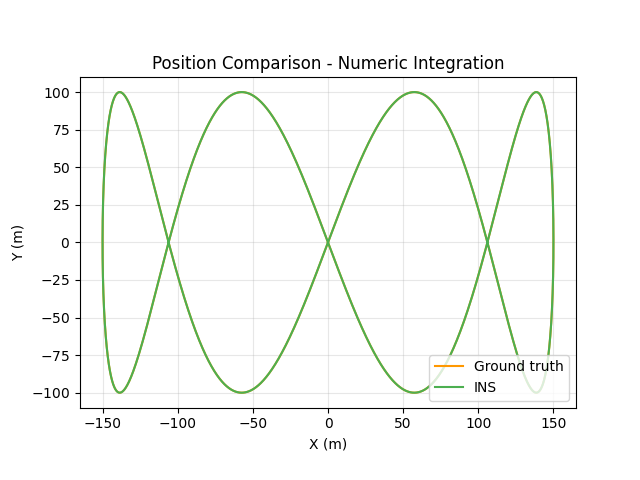

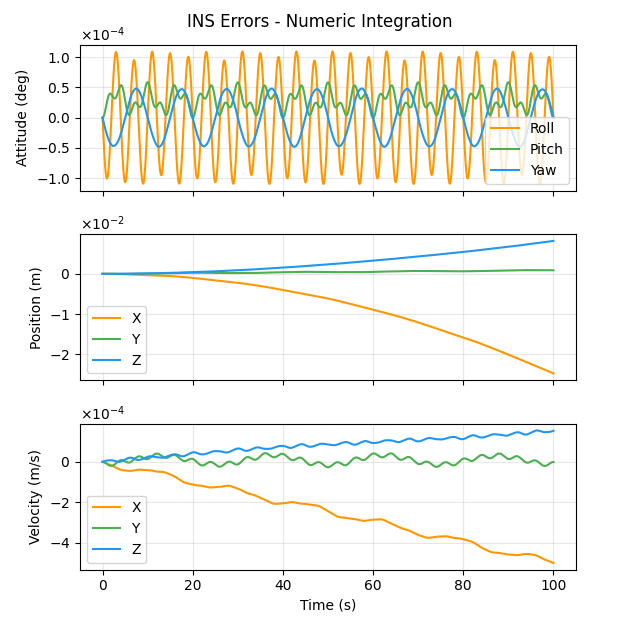

In [5]:
# The contains of plot_errors is hidden for clarity.
plot_errors(results, zigzag, " - Numeric Integration")

Attitude errors remain small and bounded.  Position errors grow to 2.5
centimeters (approximately 1 inch) and demonstrate the characteristic polynomial
error growth expected of free INS.  Velocity errors are small and primarily
linear.

## Simulate INS errors

Next we simulate gravity and initial condition errors while maintaining ideal
(error-free) IMU inputs.  These demonstrate two of the fundamental sources of
error in inertial navigation.  We modify the model and specification defined
above and re-run the same simulation.  Gravity is underestimated by 1% and a 0.1
degree error in the initial pitch angle is added to the initial conditions.
These are not random errors so their effect will be the same if the simulation
is repeated.

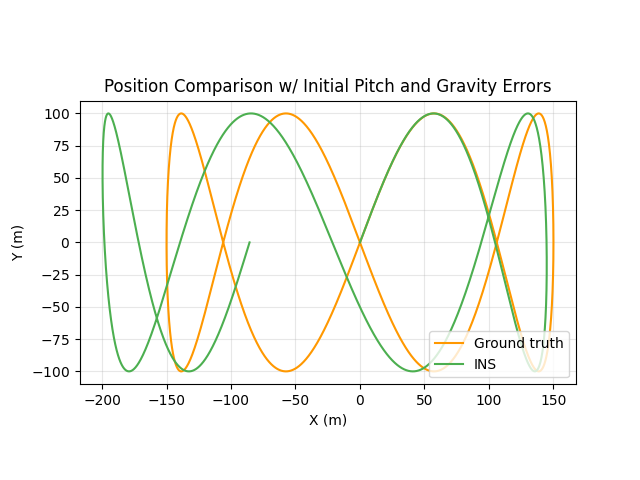

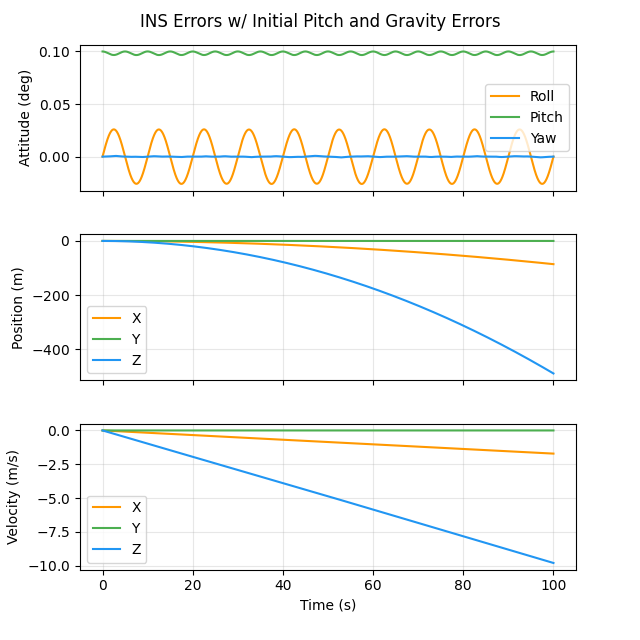

In [6]:
from inertialsim.sensors import Parameter

# Simulate gravity scale factor error and initial condition biases
model.gravity.simulate_scale_factor = True
model.initial_conditions.simulate_bias = True

# A gravity scale factor error of -0.01 underestimates gravity by 1%
specification.gravity.scale_factor = Parameter(-0.01, "dimensionless")

# An initial attitude error of 0.1 degree in pitch
specification.initial_conditions.attitude_bias = Parameter([0, 0.1, 0.0], "deg")

ins = INS(model, specification, rng=0)
ins.initialize(initial_conditions)
results = ins.simulate(angular_rate=angular_rate, specific_force=specific_force)

plot_errors(results, zigzag, title=" w/ Initial Pitch and Gravity Errors")

The initial pitch error results in an average pitch error of the same magnitude
and is coupled into other attitude errors.  Pitch error results in
mis-compensation of gravity components, which, along with the direct gravity
error results in large position and velocity errors, particularly in the z-axis.

## Simulate IMU errors

Next we simulate IMU errors.  We compare two real IMU specifications from the
[devices][inertialsim.devices] library.  These IMU specifications include random
errors which will differ each time they are simulated (subject to the `rng`
input as described in [reference](../reference/determinism.md) documentation).


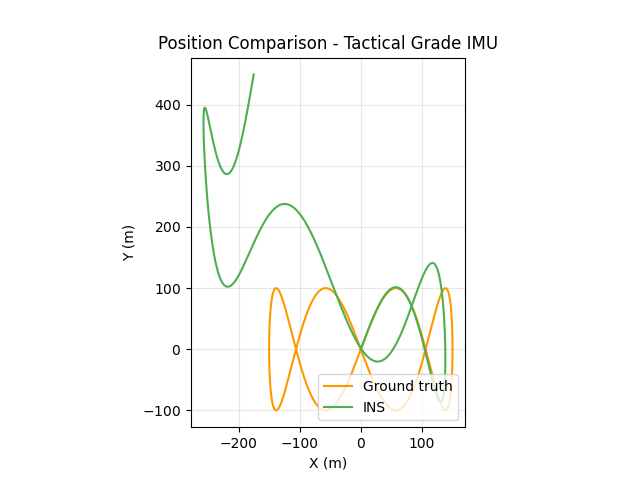

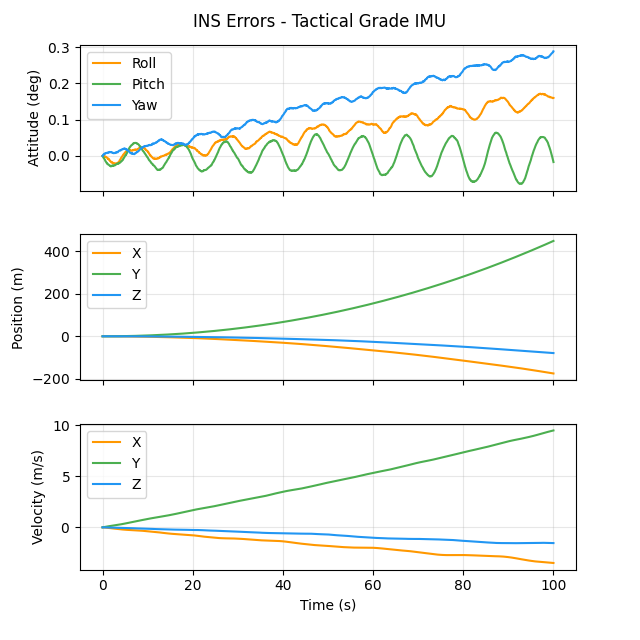

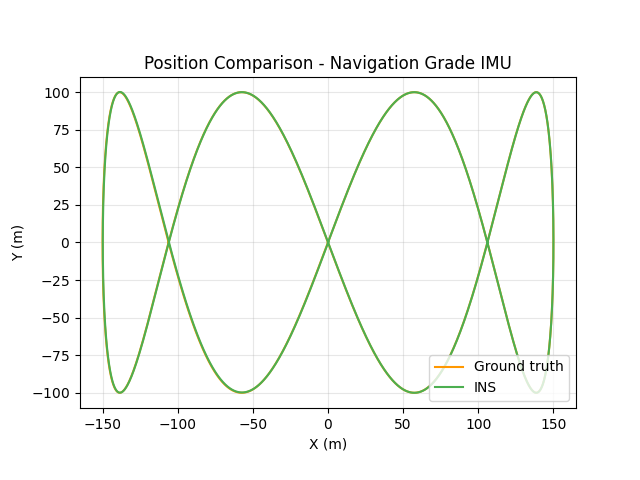

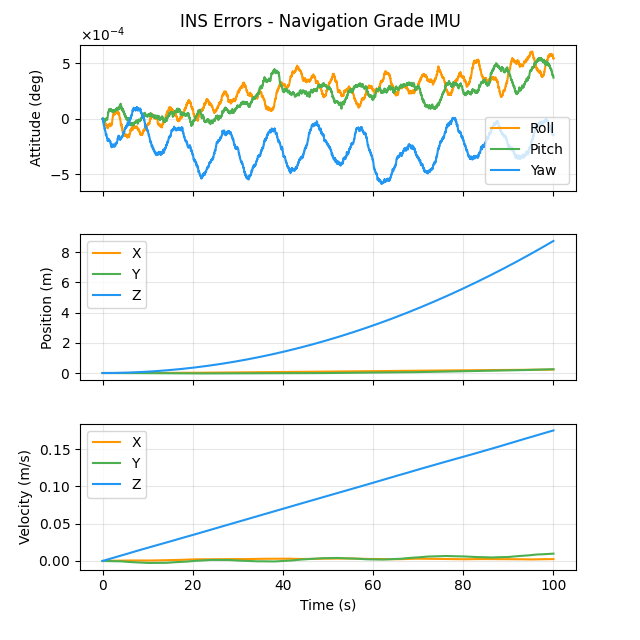

In [7]:
from inertialsim.sensors.imu import IMU, IMUModel
from inertialsim.devices.imu import honeywell_hg4930, honeywell_hg9900

# Simulate a tactical grade IMU.
imu_model = IMUModel()
imu_model.data_interface.simulate_sample_rate = False
imu = IMU(imu_model, honeywell_hg4930, rng=1)
imu_data = imu.simulate(angular_rate=angular_rate, specific_force=specific_force)

# Ideal (error-free) INS
ins_model = INSModel()
ins_model.numerical_methods.integrator = Integrator.TRAPEZOID
ins = INS(ins_model, INSSpecification(), rng=2)
ins.initialize(initial_conditions)
result = ins.simulate(
    angular_rate=imu_data.angular_rate, specific_force=imu_data.specific_force
)

plot_errors(result, zigzag, title=" - Tactical Grade IMU")

# Simulate a navigation grade IMU.
imu = IMU(imu_model, honeywell_hg9900, rng=3)
imu_data = imu.simulate(angular_rate=angular_rate, specific_force=specific_force)

# Re-simulate the INS with new IMU data
ins = INS(ins_model, INSSpecification(), rng=4)
ins.initialize(initial_conditions)
result = ins.simulate(
    angular_rate=imu_data.angular_rate, specific_force=imu_data.specific_force
)

plot_errors(result, zigzag, title=" - Navigation Grade IMU")


As expected, the navigation grade IMU performs significantly better than the
tactical grade device.  

## Monte-carlo error simulation

Simulations with random errors can be characterized by Monte-Carlo testing and
statistical error analysis.  We repeat the tactical grade IMU simulation 50
times and use the [geometry][inertialsim.geometry] module's metrics capability
([ExtendedPose.error()][inertialsim.geometry.ExtendedPose.error] in this case)
to calculate the error.  We then plot the mean and standard deviation for total
attitude, position, and velocity errors.


In [8]:
# Simulate a tactical grade IMU.
imu_model = IMUModel()
imu_model.data_interface.simulate_sample_rate = False

# Ideal (error-free) INS w/ rotation matrix output
ins_model = INSModel()
ins_model.numerical_methods.integrator = Integrator.TRAPEZOID
ins_model.data_interface.attitude_format = AttitudeFormat.ROTATION_MATRIX

# Run the sim 50x with random rng seed
results = []
for k in range(50):
    imu = IMU(imu_model, honeywell_hg4930, rng=None)
    imu_data = imu.simulate(angular_rate=angular_rate, specific_force=specific_force)
    ins = INS(ins_model, INSSpecification(), rng=None)
    ins.initialize(initial_conditions)
    result = ins.simulate(
        angular_rate=imu_data.angular_rate, specific_force=imu_data.specific_force
    )
    results.append(result)


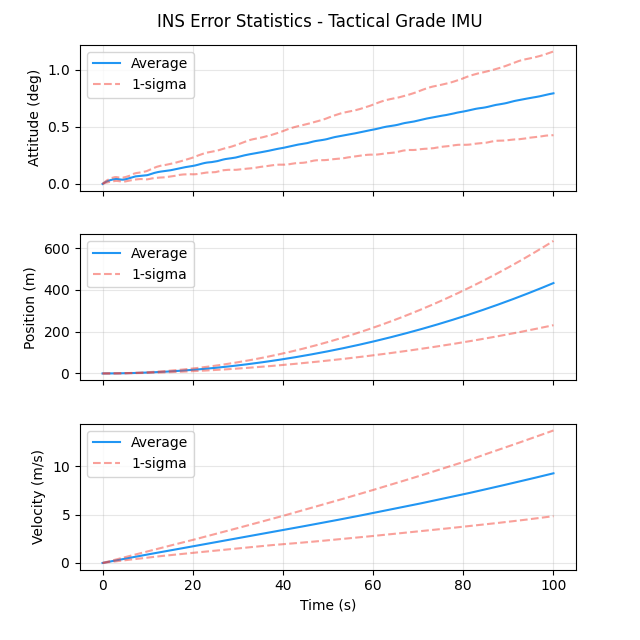

In [9]:
plot_average_errors(results, zigzag, title=" - Tactical Grade IMU")

## Simulate aided INS

Finally, we demonstrate aided INS simulation.  As with all other sensors, the
INS can be run in `batch` or `real-time` simulation modes.  In real-time mode,
IMU data is passed to the INS incrementally.  As error accumulates (see above),
the [reset()][inertialsim.sensors.ins.INS.reset] method is called periodically
to simulate corrections from an external source (e.g. GNSS).

Any combination of attitude (orientation), position, or velocity components can
be reset independently.  This allows for simulating observability constraints
depending on the aiding sensor and aiding algorithm.

In this example, all errors are reset, simulating a fully observable system such
as GNSS position measurement inputs under ideal conditions.

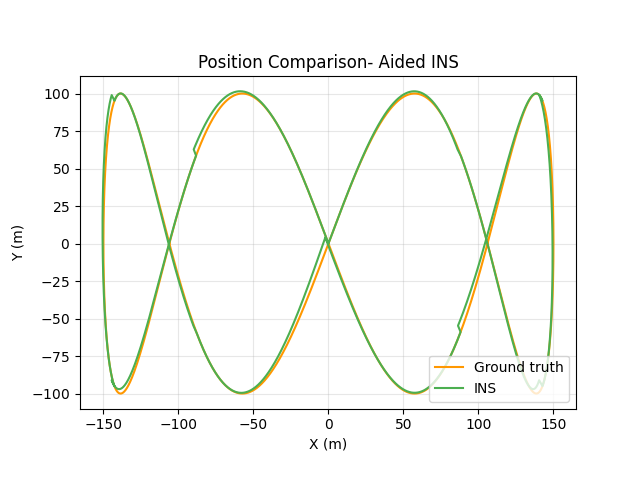

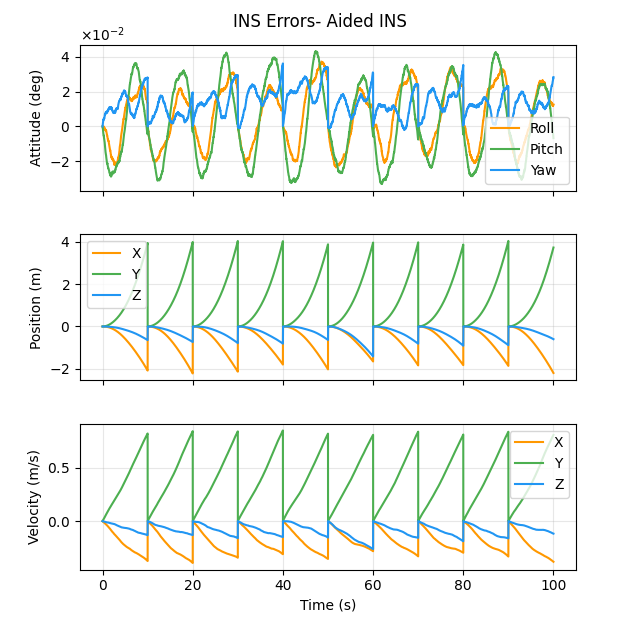

In [10]:
from inertialsim.sensors.ins import INSData
from inertialsim.sensors import Measurement

# No change to earlier IMU setup
imu = IMU(imu_model, honeywell_hg4930, rng=1)
imu_data = imu.simulate(angular_rate=angular_rate, specific_force=specific_force)

# Create and initialize the INS
ins_model.data_interface.attitude_format = AttitudeFormat.EULER_ANGLE
ins = INS(model=ins_model, specification=INSSpecification(), rng=0, mode="real-time")
data = ins.initialize(
    initial_conditions, imu_data.angular_rate[0], imu_data.specific_force[0]
)
# Incrementally simulate and store the INS data
ins_data = []
ins_data.append(data)
for k in range(1, time.shape[0]):
    data = ins.simulate(
        angular_rate=imu_data.angular_rate[k],
        specific_force=imu_data.specific_force[k],
    )
    ins_data.append(data)

    # Every 1000 steps (10s at 100Hz) simulate a full reset from an aiding sensor
    if np.mod(k, 1000) == 0:
        ins.reset(
            attitude=zigzag.rotation(time[k]),
            position=Vector.from_xyz(zigzag.position(time[k])),
            velocity=Vector.from_xyz(zigzag.velocity(time[k])),
        )

results = INSData(
    attitude=Measurement.from_measurements([m.attitude for m in ins_data]),
    position=Measurement.from_measurements([m.position for m in ins_data]),
    velocity=Measurement.from_measurements([m.velocity for m in ins_data]),
)

plot_errors(results, zigzag, title="- Aided INS")

The resulting errors have the characteristic "saw-tooth" profile of aided INS
systems.  Error accumulates (or "drifts") and is then reset, and repeat.

## Applications and use cases

The [`INS`][inertialsim.sensors.ins] module provides a complete INS simulation
capability.  Use cases include:

* IMU trade studies.
* Navigation system error budgeting.  
* Development of custom aided inertial navigation systems.  
* Validation of third-party algorithms or software.
* Limit and edge-case testing.
* ... and many more

[Get in touch](../contact/index.md) if you are interested in
more information!